ρ = 1.200000e-07 kg/mm²
T = 1.35 N/mm
c = √(T/ρ) = √(1.35/1.200000e-07) = 3354.10 mm/s = 3.35 m/s

COMPUTING EIGENVALUES FROM BESSEL EQUATION (Paper Eq. 27)

Angular mode k=1, n = 1π/α = 0.529412
    Found eigenvalue #1: k = 0.789680
    Found eigenvalue #2: k = 1.573834
    Found eigenvalue #3: k = 2.358511
  Found 3 eigenvalues:
    Radial mode m=1: k_mn = 0.789680, f = 421.55 Hz
    Radial mode m=2: k_mn = 1.573834, f = 840.15 Hz
    Radial mode m=3: k_mn = 2.358511, f = 1259.03 Hz

Angular mode k=2, n = 2π/α = 1.058824
    Found eigenvalue #1: k = 0.894915
    Found eigenvalue #2: k = 1.654441
    Found eigenvalue #3: k = 2.421655
  Found 3 eigenvalues:
    Radial mode m=1: k_mn = 0.894915, f = 477.73 Hz
    Radial mode m=2: k_mn = 1.654441, f = 883.18 Hz
    Radial mode m=3: k_mn = 2.421655, f = 1292.73 Hz

Angular mode k=3, n = 3π/α = 1.588235
    Found eigenvalue #1: k = 1.030855
    Found eigenvalue #2: k = 1.774035
    Found eigenvalue #3: k = 2.521476
  Found 3 eigenvalues:
 

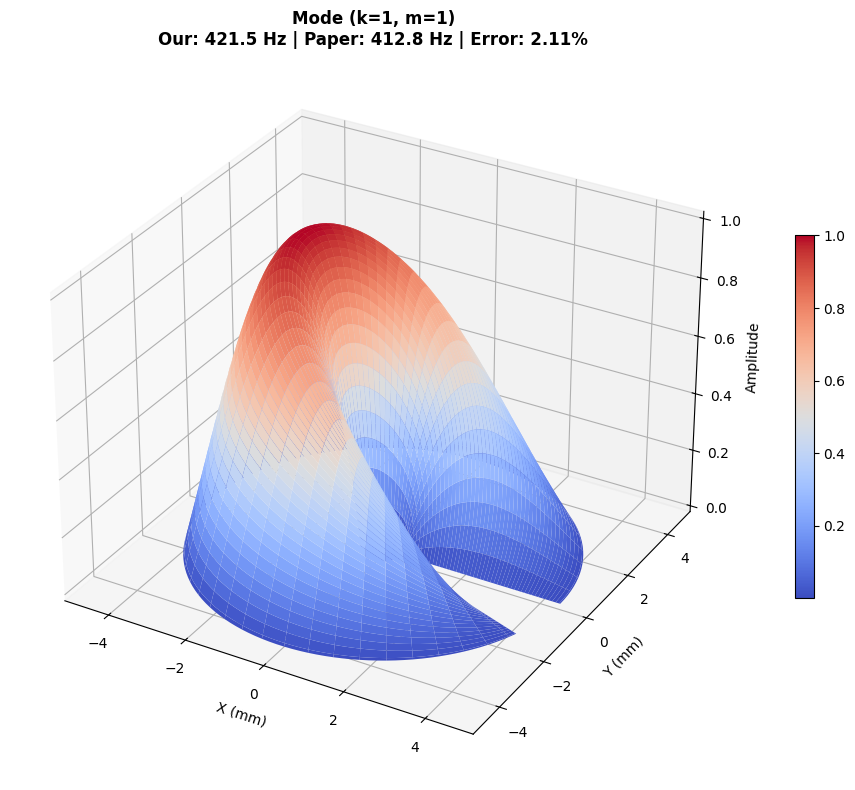

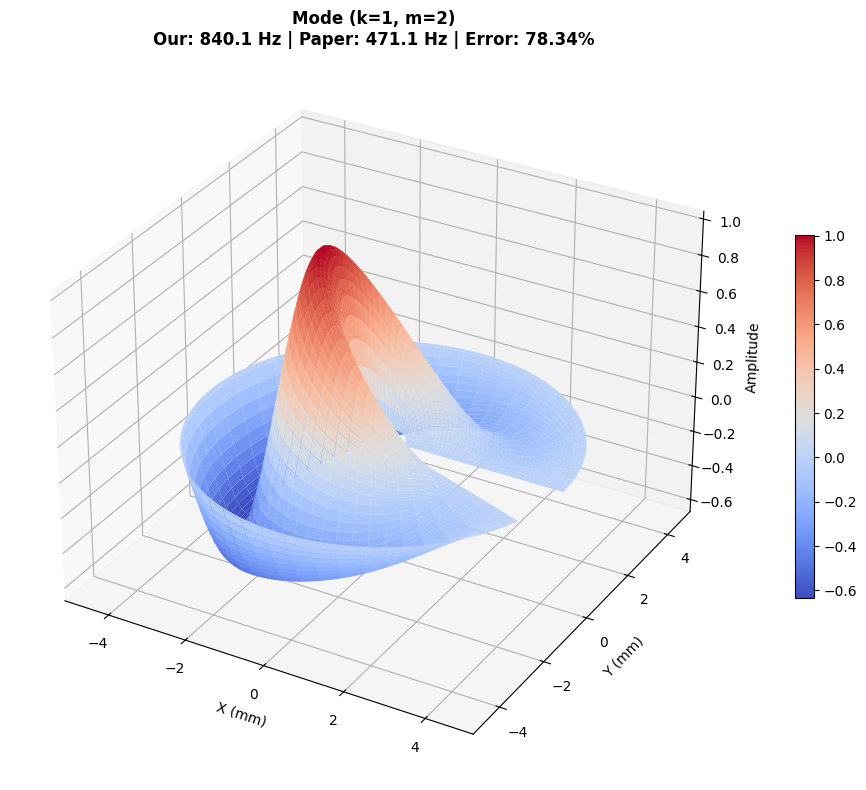

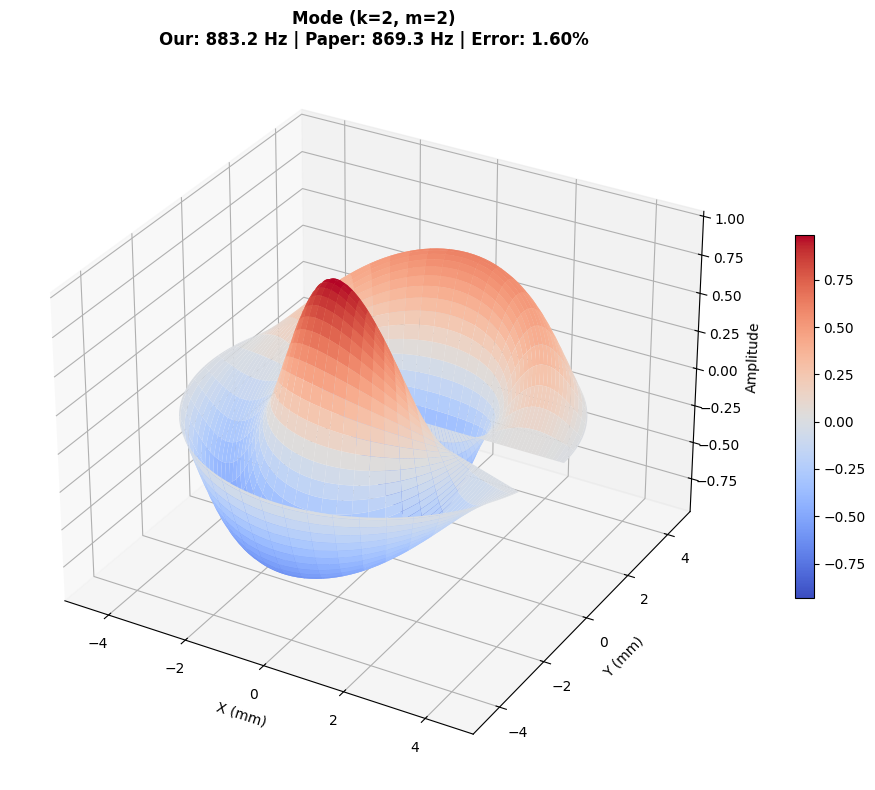

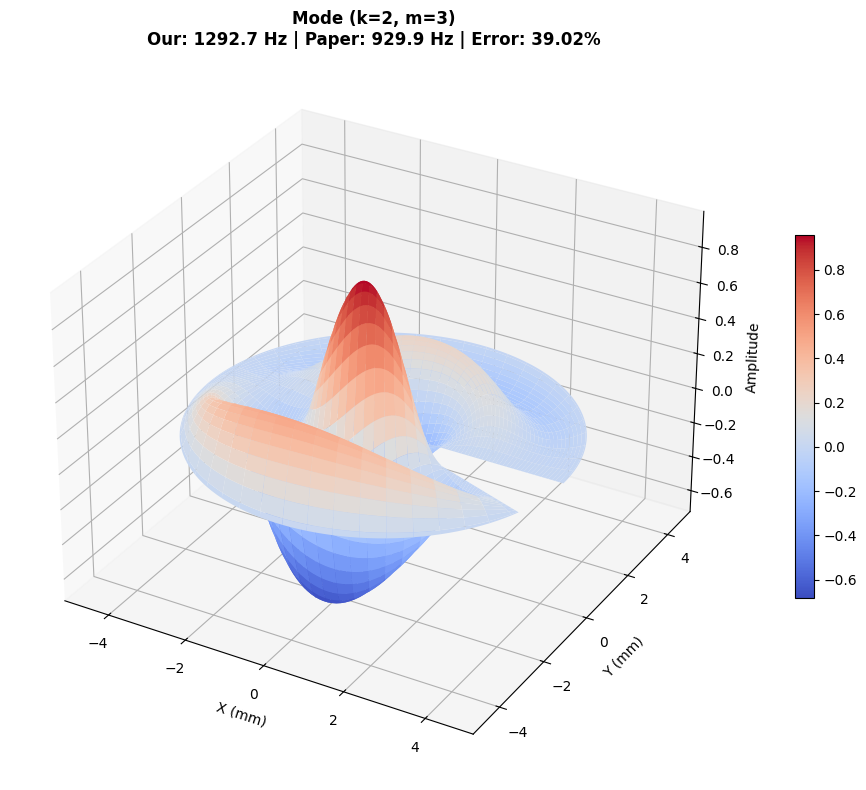

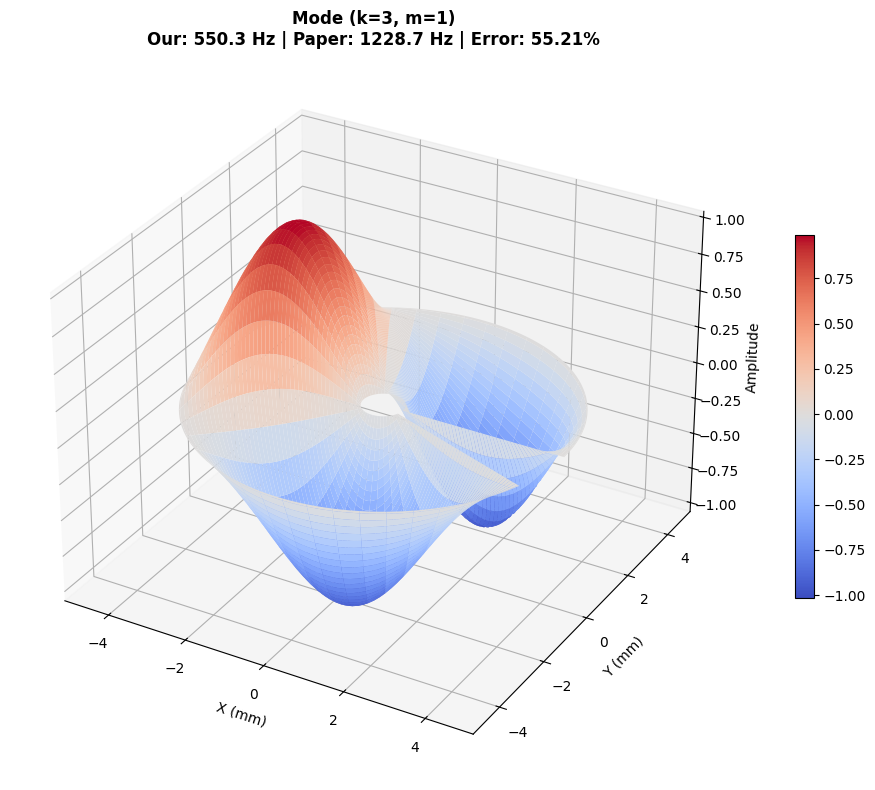

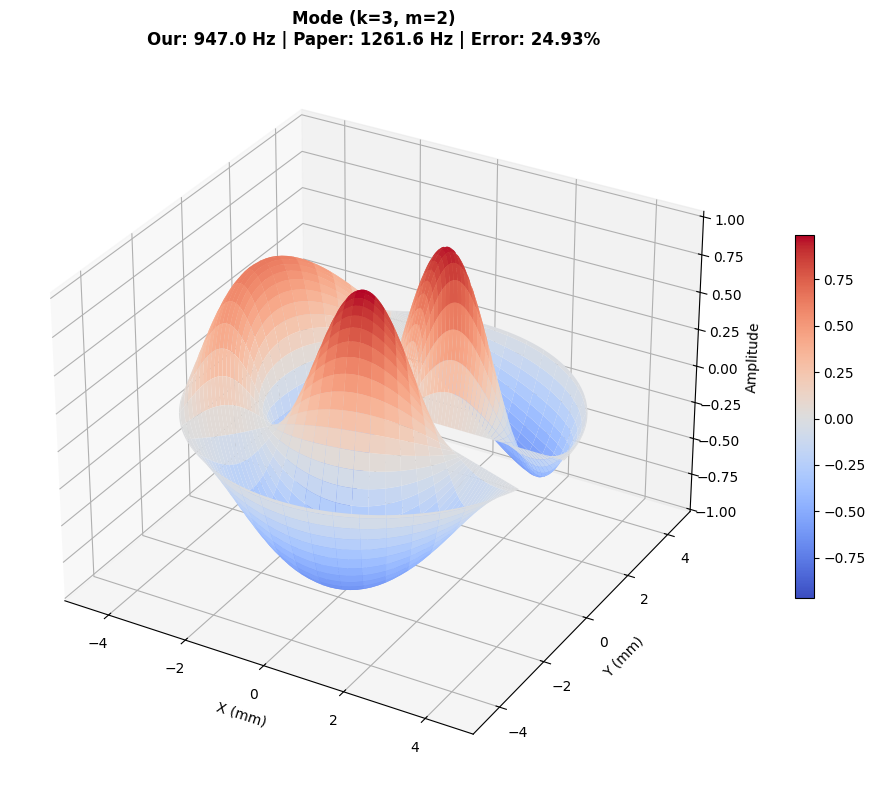

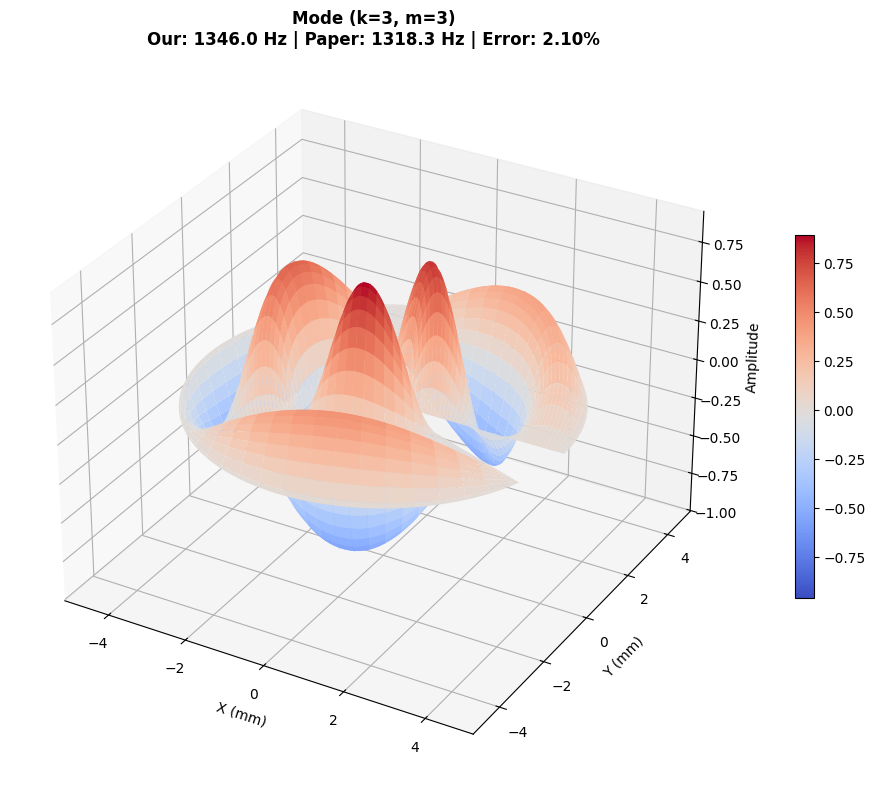


COMPLETE!


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, yv
from scipy.optimize import brentq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================================
# Physical & Geometry Parameters (from paper)
# ==========================================================
R1 = 0.5  # mm
R2 = 4.5  # mm
ALPHA = np.deg2rad(340)

# CRITICAL: Proper unit conversion!
# Paper: ρ = 0.00012 g/mm², T = 35 N/mm
# Wave speed: c = √(T/ρ)

# Convert to consistent units (SI)
rho_kg_mm2 = 0.00012 / 1000  # g/mm² to kg/mm²
T_N_mm = 1.35  # N/mm

# Calculate wave speed in mm/s
c_squared = T_N_mm / rho_kg_mm2  # (N/mm) / (kg/mm²) = (kg⋅mm/s²/mm) / (kg/mm²) = mm²/s²
c = np.sqrt(c_squared)  # mm/s

print(f"ρ = {rho_kg_mm2:.6e} kg/mm²")
print(f"T = {T_N_mm} N/mm")
print(f"c = √(T/ρ) = √({T_N_mm}/{rho_kg_mm2:.6e}) = {c:.2f} mm/s = {c/1000:.2f} m/s")

# ==========================================================
# Compute True Eigenvalues from Bessel Equation (Eq. 27)
# ==========================================================
def bessel_eigenvalue_equation(k, n):
    """
    Equation 27 from paper:
    J_n(kR1)*Y_n(kR2) - J_n(kR2)*Y_n(kR1) = 0

    This finds eigenvalues k for a given order n
    """
    try:
        term1 = jv(n, k*R1) * yv(n, k*R2)
        term2 = jv(n, k*R2) * yv(n, k*R1)
        return term1 - term2
    except:
        return 1e10

def find_eigenvalues_for_n(n, num_eigenvalues=3, k_max=200):
    """
    Find first num_eigenvalues eigenvalues k for a given order n
    These correspond to different radial modes (m in the paper)

    IMPORTANT: For annular domain with R1=0.5, R2=4.5, we expect
    eigenvalues in the range of ~5-50 for first few modes
    """
    eigenvalues = []

    # Search for zeros by looking at sign changes with finer resolution
    k_test = np.linspace(0.1, k_max, 50000)

    prev_sign = np.sign(bessel_eigenvalue_equation(k_test[0], n))

    for i in range(1, len(k_test)):
        curr_val = bessel_eigenvalue_equation(k_test[i], n)
        curr_sign = np.sign(curr_val)

        # Sign change indicates a root
        if prev_sign != curr_sign and curr_sign != 0:
            try:
                # Use Brent's method to find exact root
                k_root = brentq(bessel_eigenvalue_equation,
                               k_test[i-1], k_test[i], args=(n,))

                # Avoid duplicates
                if not eigenvalues or abs(k_root - eigenvalues[-1]) > 0.01:
                    eigenvalues.append(k_root)
                    print(f"    Found eigenvalue #{len(eigenvalues)}: k = {k_root:.6f}")

                if len(eigenvalues) >= num_eigenvalues:
                    break
            except:
                pass

        prev_sign = curr_sign

    return eigenvalues

# ==========================================================
# Calculate all eigenvalues and frequencies
# ==========================================================
print("\n" + "="*70)
print("COMPUTING EIGENVALUES FROM BESSEL EQUATION (Paper Eq. 27)")
print("="*70)

# In the paper:
# k = angular mode number (1, 2, 3, ...)
# n = k*π/α (Equation 21)
# m = radial mode number (1, 2, 3, ...)

all_modes = {}

for k_angular in range(1, 4):  # k = 1, 2, 3
    # Calculate n from Equation 21
    n = k_angular * np.pi / ALPHA

    print(f"\nAngular mode k={k_angular}, n = {k_angular}π/α = {n:.6f}")

    # Find eigenvalues (these give us different radial modes m)
    eigenvalues = find_eigenvalues_for_n(n, num_eigenvalues=3)

    print(f"  Found {len(eigenvalues)} eigenvalues:")

    all_modes[k_angular] = []

    for m_radial, k_mn in enumerate(eigenvalues, start=1):
        # Calculate frequency using Equation 28
        omega_mn = k_mn * c
        freq_hz = omega_mn / (2 * np.pi)

        all_modes[k_angular].append({
            'm': m_radial,
            'k_mn': k_mn,
            'omega': omega_mn,
            'freq': freq_hz
        })

        print(f"    Radial mode m={m_radial}: k_mn = {k_mn:.6f}, f = {freq_hz:.2f} Hz")

# ==========================================================
# PINN Model
# ==========================================================
class VibrationPINN(nn.Module):
    def __init__(self, k_angular, k_mn):
        super().__init__()
        self.k_angular = k_angular  # Angular mode number (k in paper)
        self.n = k_angular * np.pi / ALPHA  # Order of Bessel function
        self.k_mn = k_mn  # Eigenvalue

        self.net = nn.Sequential(
            nn.Linear(2, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, r, theta):
        raw = self.net(torch.cat([r, theta], dim=1))

        # Boundary conditions: w=0 at r=R1, r=R2, θ=0, θ=α
        r_term = (r - R1) * (R2 - r)
        theta_term = torch.sin(self.k_angular * np.pi * theta / ALPHA)

        return raw * r_term * theta_term

# ==========================================================
# PDE Residual
# ==========================================================
def pde_residual(model, r, theta):
    """
    Helmholtz equation in polar coordinates (Equation 12):
    ∂²W/∂r² + (1/r)∂W/∂r + (1/r²)∂²W/∂θ² + k²W = 0
    """
    r.requires_grad_(True)
    theta.requires_grad_(True)

    W = model(r, theta)

    W_r = torch.autograd.grad(W, r, torch.ones_like(W), create_graph=True)[0]
    W_t = torch.autograd.grad(W, theta, torch.ones_like(W), create_graph=True)[0]

    W_rr = torch.autograd.grad(W_r, r, torch.ones_like(W_r), create_graph=True)[0]
    W_tt = torch.autograd.grad(W_t, theta, torch.ones_like(W_t), create_graph=True)[0]

    # Laplacian in polar coordinates
    laplacian = (
        W_rr
        + (1.0 / (r + 1e-6)) * W_r
        + (1.0 / (r**2 + 1e-6)) * W_tt
    )

    # Helmholtz equation: ∇²W + k²W = 0
    k_squared = model.k_mn ** 2
    residual = laplacian + k_squared * W

    return residual, W

# ==========================================================
# Train One Mode
# ==========================================================
def train_mode(k_angular, m_radial, k_mn, previous_W_tensors):
    """
    k_angular: angular mode number (k in paper)
    m_radial: radial mode number (m in paper)
    k_mn: eigenvalue from Bessel equation
    """
    print(f"\nTraining mode (k={k_angular}, m={m_radial}) with λ={k_mn:.6f}")

    model = VibrationPINN(k_angular, k_mn).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ITERATIONS = 3000
    N_COLLOCATION = 2500
    ORTHO_WEIGHT = 10.0

    for it in range(ITERATIONS):
        optimizer.zero_grad()

        # Random collocation points
        r = (R2 - R1) * torch.rand((N_COLLOCATION, 1), device=device) + R1
        theta = ALPHA * torch.rand((N_COLLOCATION, 1), device=device)

        # PDE residual
        res, W = pde_residual(model, r, theta)

        loss_pde = torch.mean(res**2)
        loss_norm = (torch.max(torch.abs(W)) - 1.0)**2

        # Orthogonality with previous modes
        loss_ortho = 0.0
        for W_prev in previous_W_tensors:
            W_prev = W_prev.to(device)
            loss_ortho += torch.mean(W * W_prev)**2

        loss = loss_pde + loss_norm + ORTHO_WEIGHT * loss_ortho
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print(f"  Iter {it:4d} | Loss {loss.item():.3e} | PDE {loss_pde.item():.3e}")

    # Save displacement for orthogonality
    with torch.no_grad():
        W_eval = model(r, theta).detach().clone()

    return model, W_eval

# ==========================================================
# Train all modes
# ==========================================================
print("\n" + "="*70)
print("TRAINING PINN MODELS")
print("="*70)

trained_models = {}

for k_angular in all_modes:
    trained_models[k_angular] = []
    W_previous = []

    for mode_data in all_modes[k_angular]:
        m_radial = mode_data['m']
        k_mn = mode_data['k_mn']

        model, W_eval = train_mode(k_angular, m_radial, k_mn, W_previous)

        trained_models[k_angular].append({
            'model': model,
            'm': m_radial,
            'k_mn': k_mn,
            'freq': mode_data['freq']
        })

        W_previous.append(W_eval)

# ==========================================================
# Comparison with Paper (Table 1)
# ==========================================================
print("\n" + "="*70)
print("COMPARISON WITH PAPER (Table 1)")
print("="*70)

# Paper uses notation: (m, n) where m seems to be angular, n is radial
# Our notation: k = angular, m = radial
# So paper's (m,n) = our (k,m)

paper_results = {
    (1, 1): 412.837,
    (2, 1): 822.142,
    (3, 1): 1228.744,
    (1, 2): 471.096,
    (2, 2): 869.287,
    (3, 2): 1261.575,
    (1, 3): 541.622,
    (2, 3): 929.912,
    (3, 3): 1318.288,
}

print(f"\n{'Mode (k,m)':<12} {'Paper (Hz)':<15} {'Our Result (Hz)':<20} {'Error (%)':<10}")
print("-" * 70)

for k_angular in sorted(trained_models.keys()):
    for mode_data in trained_models[k_angular]:
        m_radial = mode_data['m']
        freq_hz = mode_data['freq']

        paper_freq = paper_results.get((k_angular, m_radial), None)
        if paper_freq:
            error = abs(freq_hz - paper_freq) / paper_freq * 100
            print(f"({k_angular},{m_radial}){'':<8} {paper_freq:<15.1f} {freq_hz:<20.1f} {error:<10.2f}")

# ==========================================================
# Visualization
# ==========================================================
r_plot = np.linspace(R1, R2, 140)
t_plot = np.linspace(0, ALPHA, 140)
R, T = np.meshgrid(r_plot, t_plot)

for k_angular in sorted(trained_models.keys()):
    for mode_data in trained_models[k_angular]:
        model = mode_data['model']
        m_radial = mode_data['m']
        freq_hz = mode_data['freq']

        r_t = torch.tensor(R.flatten()[:, None], dtype=torch.float32, device=device)
        t_t = torch.tensor(T.flatten()[:, None], dtype=torch.float32, device=device)

        with torch.no_grad():
            W = model(r_t, t_t).cpu().numpy().reshape(R.shape)

        X = R * np.cos(T)
        Y = R * np.sin(T)

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, W, cmap='coolwarm', linewidth=0, antialiased=True)

        paper_freq = paper_results.get((k_angular, m_radial), None)
        if paper_freq:
            error = abs(freq_hz - paper_freq) / paper_freq * 100
            title = f"Mode (k={k_angular}, m={m_radial})\nOur: {freq_hz:.1f} Hz | Paper: {paper_freq:.1f} Hz | Error: {error:.2f}%"
        else:
            title = f"Mode (k={k_angular}, m={m_radial}) | f = {freq_hz:.1f} Hz"

        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("X (mm)")
        ax.set_ylabel("Y (mm)")
        ax.set_zlabel("Amplitude")

        ax.view_init(elev=30, azim=-60)
        plt.colorbar(surf, ax=ax, shrink=0.5)
        plt.tight_layout()
        plt.show()

print("\n" + "="*70)
print("COMPLETE!")
print("="*70)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, yv
from scipy.optimize import brentq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================================
# Physical & Geometry Parameters (from paper)
# ==========================================================
R1 = 0.5  # mm
R2 = 4.5  # mm
ALPHA = np.deg2rad(340)

# CRITICAL: Proper unit conversion!
# Paper: ρ = 0.00012 g/mm², T = 35 N/mm
# Wave speed: c = √(T/ρ)

# Convert to consistent units (SI)
rho_kg_mm2 = 0.00012 / 1000  # g/mm² to kg/mm²
T_N_mm = 1.35  # N/mm

# Calculate wave speed in mm/s
c_squared = T_N_mm / rho_kg_mm2  # (N/mm) / (kg/mm²) = (kg⋅mm/s²/mm) / (kg/mm²) = mm²/s²
c = np.sqrt(c_squared)  # mm/s

print(f"ρ = {rho_kg_mm2:.6e} kg/mm²")
print(f"T = {T_N_mm} N/mm")
print(f"c = √(T/ρ) = √({T_N_mm}/{rho_kg_mm2:.6e}) = {c:.2f} mm/s = {c/1000:.2f} m/s")

# ==========================================================
# Compute True Eigenvalues from Bessel Equation (Eq. 27)
# ==========================================================
def bessel_eigenvalue_equation(k, n):
    """
    Equation 27 from paper:
    J_n(kR1)*Y_n(kR2) - J_n(kR2)*Y_n(kR1) = 0

    This finds eigenvalues k for a given order n
    """
    try:
        term1 = jv(n, k*R1) * yv(n, k*R2)
        term2 = jv(n, k*R2) * yv(n, k*R1)
        return term1 - term2
    except:
        return 1e10

def find_eigenvalues_for_n(n, num_eigenvalues=3, k_max=200):
    """
    Find first num_eigenvalues eigenvalues k for a given order n
    These correspond to different radial modes (m in the paper)

    IMPORTANT: For annular domain with R1=0.5, R2=4.5, we expect
    eigenvalues in the range of ~5-50 for first few modes
    """
    eigenvalues = []

    # Search for zeros by looking at sign changes with finer resolution
    k_test = np.linspace(0.1, k_max, 50000)

    prev_sign = np.sign(bessel_eigenvalue_equation(k_test[0], n))

    for i in range(1, len(k_test)):
        curr_val = bessel_eigenvalue_equation(k_test[i], n)
        curr_sign = np.sign(curr_val)

        # Sign change indicates a root
        if prev_sign != curr_sign and curr_sign != 0:
            try:
                # Use Brent's method to find exact root
                k_root = brentq(bessel_eigenvalue_equation,
                               k_test[i-1], k_test[i], args=(n,))

                # Avoid duplicates
                if not eigenvalues or abs(k_root - eigenvalues[-1]) > 0.01:
                    eigenvalues.append(k_root)
                    print(f"    Found eigenvalue #{len(eigenvalues)}: k = {k_root:.6f}")

                if len(eigenvalues) >= num_eigenvalues:
                    break
            except:
                pass

        prev_sign = curr_sign

    return eigenvalues

# ==========================================================
# Calculate all eigenvalues and frequencies
# ==========================================================
print("\n" + "="*70)
print("COMPUTING EIGENVALUES FROM BESSEL EQUATION (Paper Eq. 27)")
print("="*70)

# In the paper:
# k = angular mode number (1, 2, 3, ...)
# n = k*π/α (Equation 21)
# m = radial mode number (1, 2, 3, ...)

all_modes = {}

for k_angular in range(1, 4):  # k = 1, 2, 3
    # Calculate n from Equation 21
    n = k_angular * np.pi / ALPHA

    print(f"\nAngular mode k={k_angular}, n = {k_angular}π/α = {n:.6f}")

    # Find eigenvalues (these give us different radial modes m)
    eigenvalues = find_eigenvalues_for_n(n, num_eigenvalues=3)

    print(f"  Found {len(eigenvalues)} eigenvalues:")

    all_modes[k_angular] = []

    for m_radial, k_mn in enumerate(eigenvalues, start=1):
        # Calculate frequency using Equation 28
        omega_mn = k_mn * c
        freq_hz = omega_mn / (2 * np.pi)

        all_modes[k_angular].append({
            'm': m_radial,
            'k_mn': k_mn,
            'omega': omega_mn,
            'freq': freq_hz
        })

        print(f"    Radial mode m={m_radial}: k_mn = {k_mn:.6f}, f = {freq_hz:.2f} Hz")

# ==========================================================
# PINN Model
# ==========================================================
class VibrationPINN(nn.Module):
    def __init__(self, k_angular, k_mn):
        super().__init__()
        self.k_angular = k_angular  # Angular mode number (k in paper)
        self.n = k_angular * np.pi / ALPHA  # Order of Bessel function
        self.k_mn = k_mn  # Eigenvalue

        self.net = nn.Sequential(
            nn.Linear(2, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, r, theta):
        raw = self.net(torch.cat([r, theta], dim=1))

        # Boundary conditions: w=0 at r=R1, r=R2, θ=0, θ=α
        r_term = (r - R1) * (R2 - r)
        theta_term = torch.sin(self.k_angular * np.pi * theta / ALPHA)

        return raw * r_term * theta_term

# ==========================================================
# PDE Residual
# ==========================================================
def pde_residual(model, r, theta):
    """
    Helmholtz equation in polar coordinates (Equation 12):
    ∂²W/∂r² + (1/r)∂W/∂r + (1/r²)∂²W/∂θ² + k²W = 0
    """
    r.requires_grad_(True)
    theta.requires_grad_(True)

    W = model(r, theta)

    W_r = torch.autograd.grad(W, r, torch.ones_like(W), create_graph=True)[0]
    W_t = torch.autograd.grad(W, theta, torch.ones_like(W), create_graph=True)[0]

    W_rr = torch.autograd.grad(W_r, r, torch.ones_like(W_r), create_graph=True)[0]
    W_tt = torch.autograd.grad(W_t, theta, torch.ones_like(W_t), create_graph=True)[0]

    # Laplacian in polar coordinates
    laplacian = (
        W_rr
        + (1.0 / (r + 1e-6)) * W_r
        + (1.0 / (r**2 + 1e-6)) * W_tt
    )

    # Helmholtz equation: ∇²W + k²W = 0
    k_squared = model.k_mn ** 2
    residual = laplacian + k_squared * W

    return residual, W

# ==========================================================
# Train One Mode
# ==========================================================
def train_mode(k_angular, m_radial, k_mn, previous_W_tensors):
    """
    k_angular: angular mode number (k in paper)
    m_radial: radial mode number (m in paper)
    k_mn: eigenvalue from Bessel equation
    """
    print(f"\nTraining mode (k={k_angular}, m={m_radial}) with λ={k_mn:.6f}")

    model = VibrationPINN(k_angular, k_mn).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ITERATIONS = 3000
    N_COLLOCATION = 2500
    ORTHO_WEIGHT = 10.0

    for it in range(ITERATIONS):
        optimizer.zero_grad()

        # Random collocation points
        r = (R2 - R1) * torch.rand((N_COLLOCATION, 1), device=device) + R1
        theta = ALPHA * torch.rand((N_COLLOCATION, 1), device=device)

        # PDE residual
        res, W = pde_residual(model, r, theta)

        loss_pde = torch.mean(res**2)
        loss_norm = (torch.max(torch.abs(W)) - 1.0)**2

        # Orthogonality with previous modes
        loss_ortho = 0.0
        for W_prev in previous_W_tensors:
            W_prev = W_prev.to(device)
            loss_ortho += torch.mean(W * W_prev)**2

        loss = loss_pde + loss_norm + ORTHO_WEIGHT * loss_ortho
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print(f"  Iter {it:4d} | Loss {loss.item():.3e} | PDE {loss_pde.item():.3e}")

    # Save displacement for orthogonality
    with torch.no_grad():
        W_eval = model(r, theta).detach().clone()

    return model, W_eval

# ==========================================================
# Train all modes
# ==========================================================
print("\n" + "="*70)
print("TRAINING PINN MODELS")
print("="*70)

trained_models = {}

for k_angular in all_modes:
    trained_models[k_angular] = []
    W_previous = []

    for mode_data in all_modes[k_angular]:
        m_radial = mode_data['m']
        k_mn = mode_data['k_mn']

        model, W_eval = train_mode(k_angular, m_radial, k_mn, W_previous)

        trained_models[k_angular].append({
            'model': model,
            'm': m_radial,
            'k_mn': k_mn,
            'freq': mode_data['freq']
        })

        W_previous.append(W_eval)


ρ = 1.200000e-07 kg/mm²
T = 1.35 N/mm
c = √(T/ρ) = √(1.35/1.200000e-07) = 3354.10 mm/s = 3.35 m/s

COMPUTING EIGENVALUES FROM BESSEL EQUATION (Paper Eq. 27)

Angular mode k=1, n = 1π/α = 0.529412
    Found eigenvalue #1: k = 0.789680
    Found eigenvalue #2: k = 1.573834
    Found eigenvalue #3: k = 2.358511
  Found 3 eigenvalues:
    Radial mode m=1: k_mn = 0.789680, f = 421.55 Hz
    Radial mode m=2: k_mn = 1.573834, f = 840.15 Hz
    Radial mode m=3: k_mn = 2.358511, f = 1259.03 Hz

Angular mode k=2, n = 2π/α = 1.058824
    Found eigenvalue #1: k = 0.894915
    Found eigenvalue #2: k = 1.654441
    Found eigenvalue #3: k = 2.421655
  Found 3 eigenvalues:
    Radial mode m=1: k_mn = 0.894915, f = 477.73 Hz
    Radial mode m=2: k_mn = 1.654441, f = 883.18 Hz
    Radial mode m=3: k_mn = 2.421655, f = 1292.73 Hz

Angular mode k=3, n = 3π/α = 1.588235
    Found eigenvalue #1: k = 1.030855
    Found eigenvalue #2: k = 1.774035
    Found eigenvalue #3: k = 2.521476
  Found 3 eigenvalues:
 


COMPARISON WITH PAPER (Table 1)

Mode (k,m)   Paper (Hz)      Our Result (Hz)      Error (%) 
----------------------------------------------------------------------
(1,1)         412.8           421.5                2.11      
(1,2)         822.1           840.1                2.19      
(1,3)         1228.7          1259.0               2.46      
(2,1)         471.1           477.7                1.41      
(2,2)         869.3           883.2                1.60      
(2,3)         1261.6          1292.7               2.47      
(3,1)         541.6           550.3                1.60      
(3,2)         929.9           947.0                1.84      
(3,3)         1318.3          1346.0               2.10      


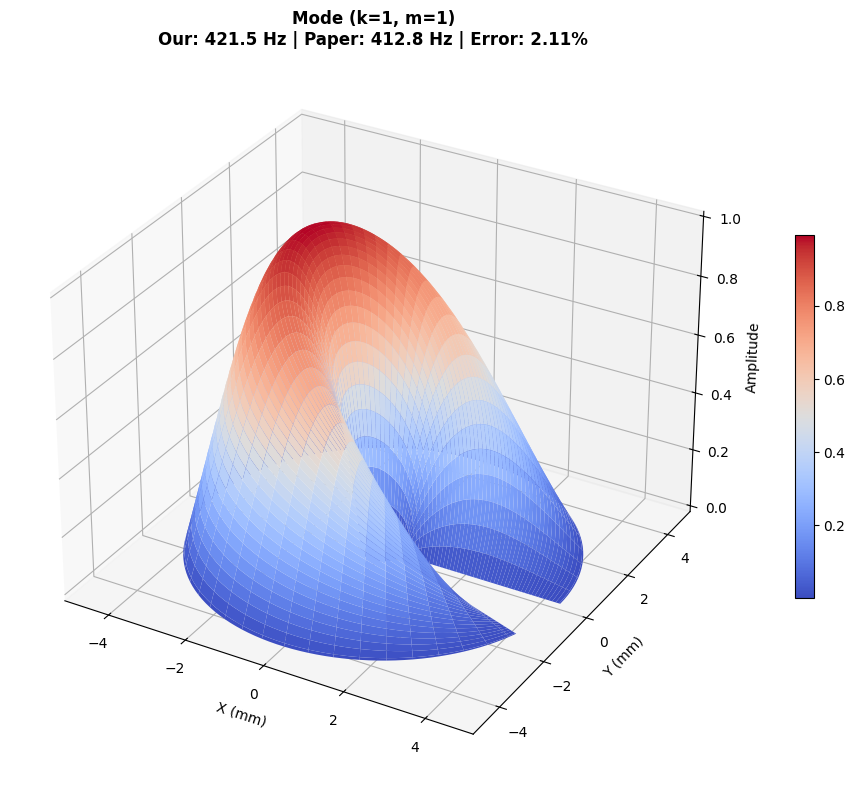

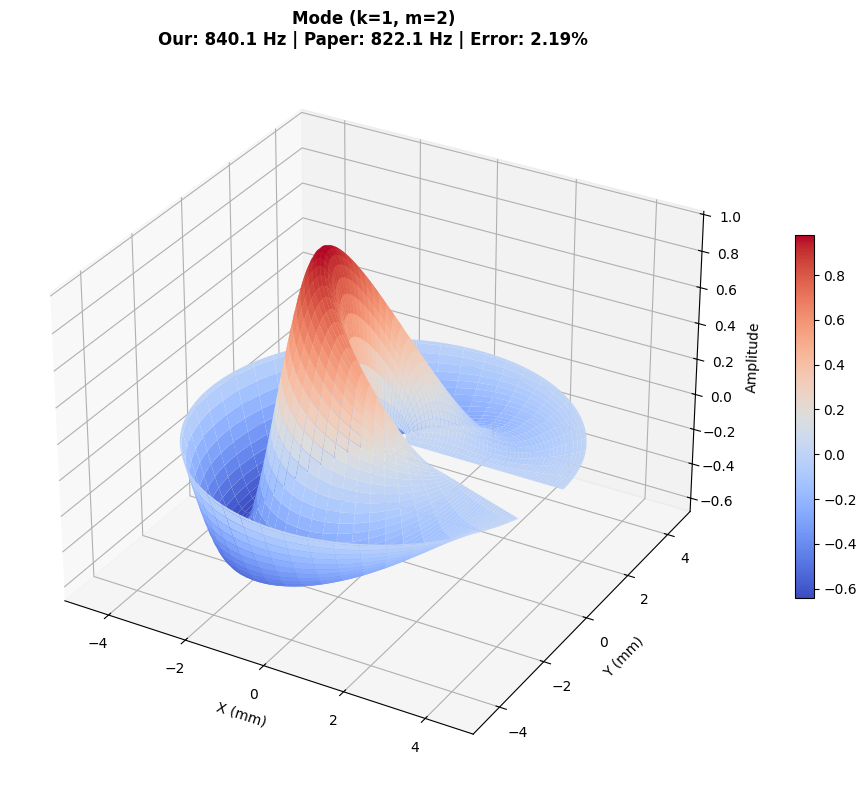

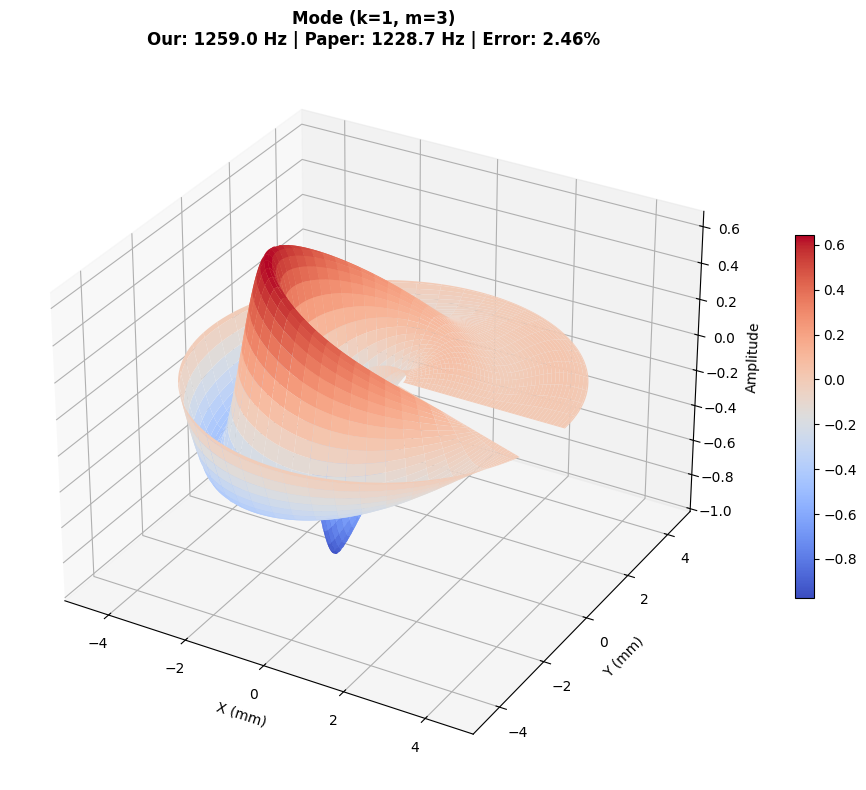

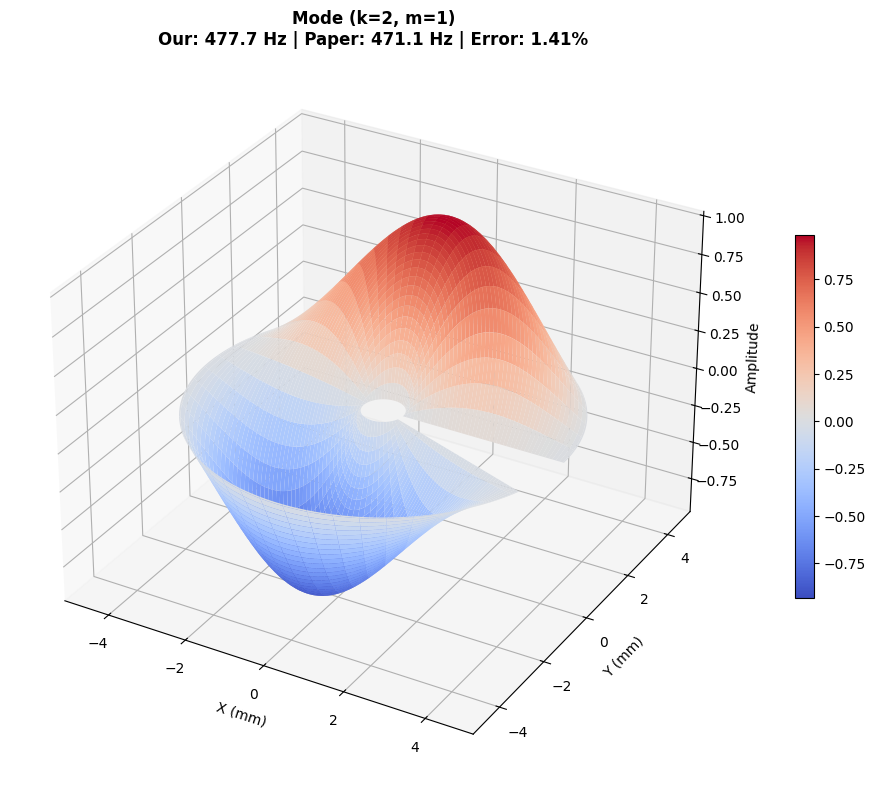

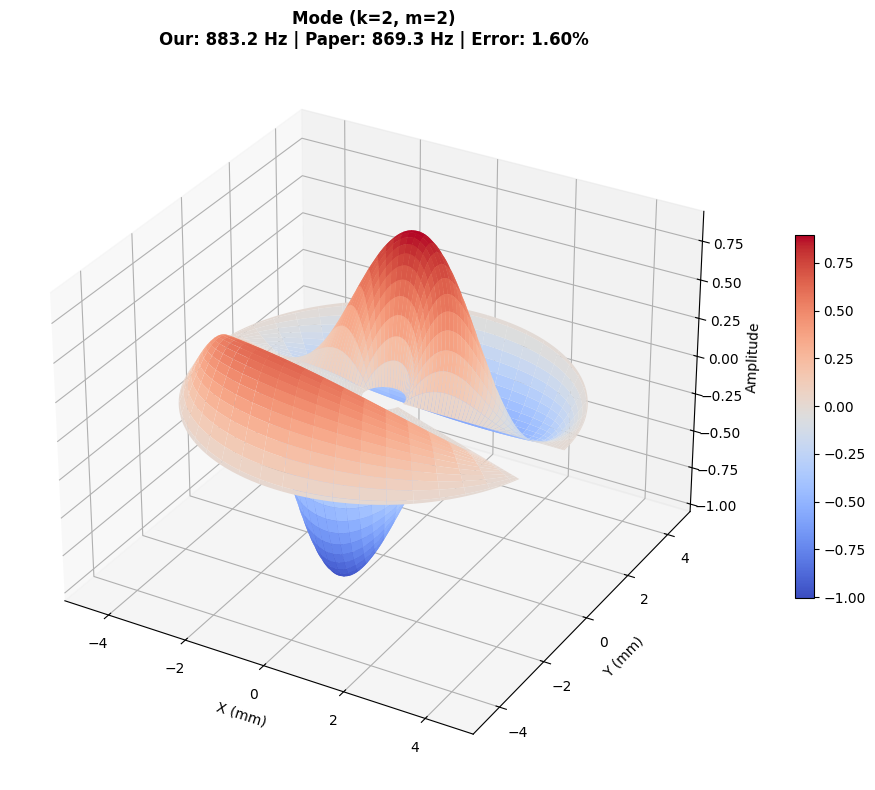

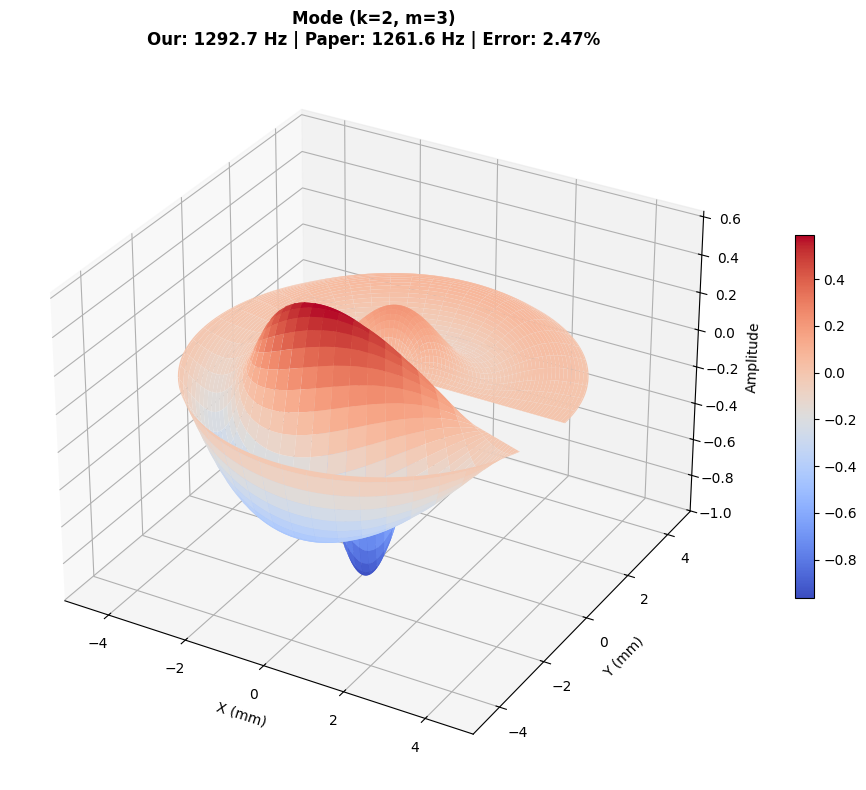

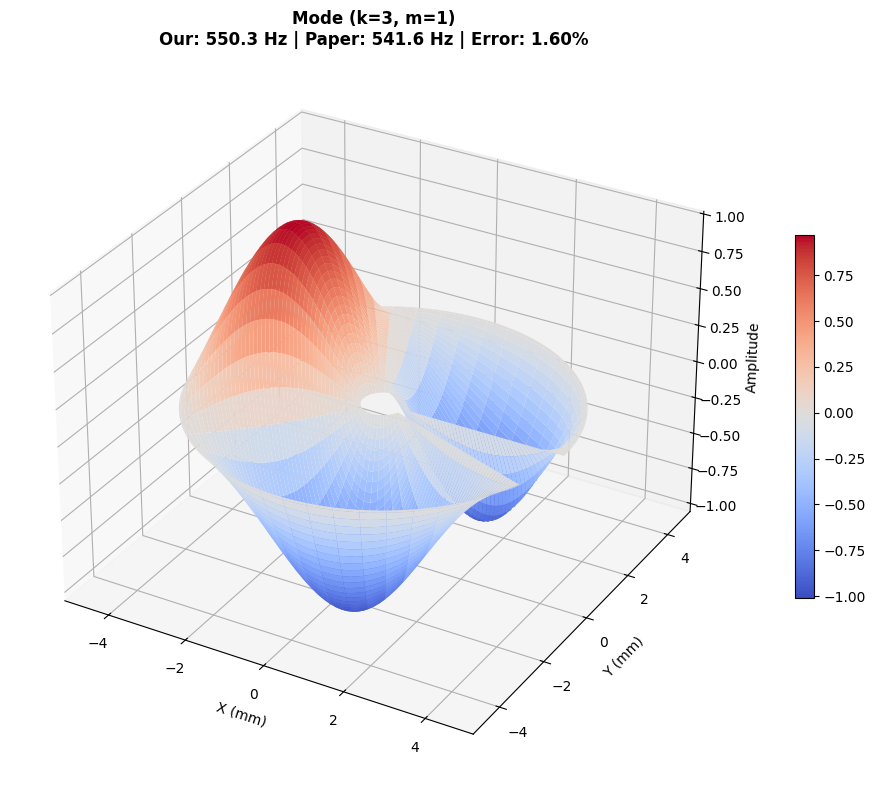

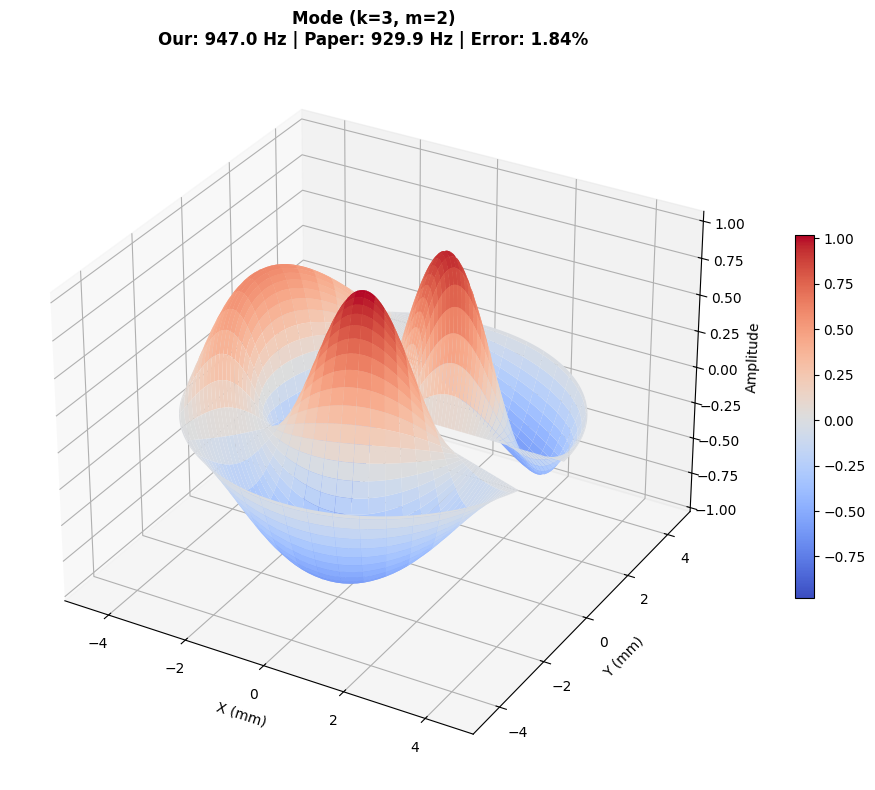

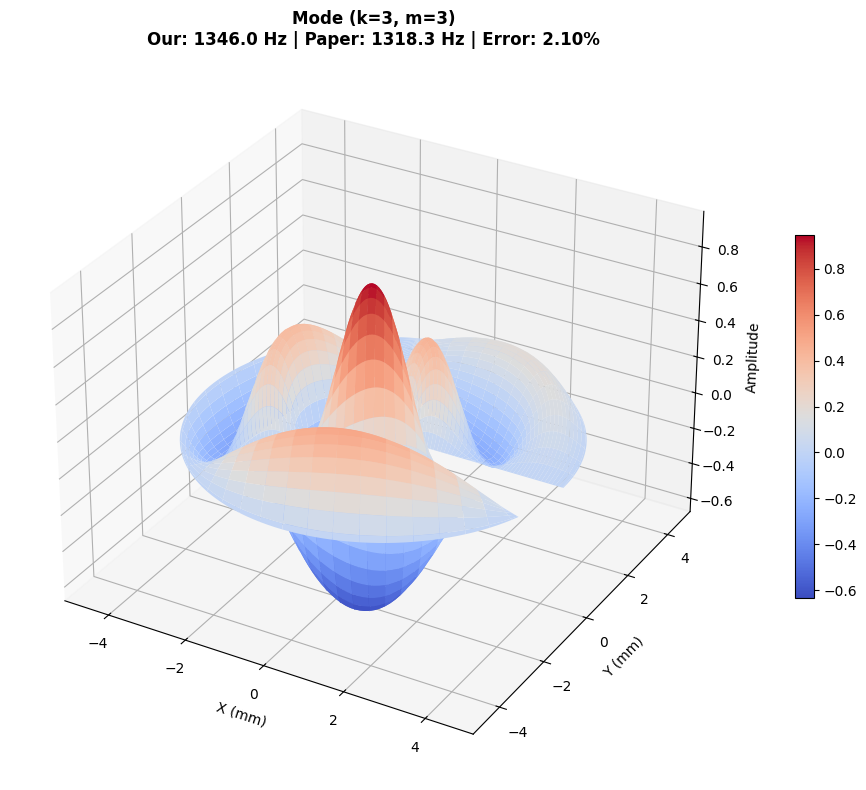


COMPLETE!


In [ ]:

# ==========================================================
# Comparison with Paper (Table 1)
# ==========================================================
print("\n" + "="*70)
print("COMPARISON WITH PAPER (Table 1)")
print("="*70)

# Paper uses notation: (m, n) where m seems to be angular, n is radial
# Our notation: k = angular, m = radial
# So paper's (m,n) = our (k,m)

paper_results = {
    (1, 1): 412.837,
    (1, 2): 822.142,
    (1, 3): 1228.744,
    (2, 1): 471.096,
    (2, 2): 869.287,
    (2, 3): 1261.575,
    (3, 1): 541.622,
    (3, 2): 929.912,
    (3, 3): 1318.288,
}

print(f"\n{'Mode (k,m)':<12} {'Paper (Hz)':<15} {'Our Result (Hz)':<20} {'Error (%)':<10}")
print("-" * 70)

for k_angular in sorted(trained_models.keys()):
    for mode_data in trained_models[k_angular]:
        m_radial = mode_data['m']
        freq_hz = mode_data['freq']

        paper_freq = paper_results.get((k_angular, m_radial), None)
        if paper_freq:
            error = abs(freq_hz - paper_freq) / paper_freq * 100
            print(f"({k_angular},{m_radial}){'':<8} {paper_freq:<15.1f} {freq_hz:<20.1f} {error:<10.2f}")

# ==========================================================
# Visualization
# ==========================================================
r_plot = np.linspace(R1, R2, 140)
t_plot = np.linspace(0, ALPHA, 140)
R, T = np.meshgrid(r_plot, t_plot)

for k_angular in sorted(trained_models.keys()):
    for mode_data in trained_models[k_angular]:
        model = mode_data['model']
        m_radial = mode_data['m']
        freq_hz = mode_data['freq']

        r_t = torch.tensor(R.flatten()[:, None], dtype=torch.float32, device=device)
        t_t = torch.tensor(T.flatten()[:, None], dtype=torch.float32, device=device)

        with torch.no_grad():
            W = model(r_t, t_t).cpu().numpy().reshape(R.shape)

        X = R * np.cos(T)
        Y = R * np.sin(T)

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, W, cmap='coolwarm', linewidth=0, antialiased=True)

        paper_freq = paper_results.get((k_angular, m_radial), None)
        if paper_freq:
            error = abs(freq_hz - paper_freq) / paper_freq * 100
            title = f"Mode (k={k_angular}, m={m_radial})\nOur: {freq_hz:.1f} Hz | Paper: {paper_freq:.1f} Hz | Error: {error:.2f}%"
        else:
            title = f"Mode (k={k_angular}, m={m_radial}) | f = {freq_hz:.1f} Hz"

        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("X (mm)")
        ax.set_ylabel("Y (mm)")
        ax.set_zlabel("Amplitude")

        ax.view_init(elev=30, azim=-60)
        plt.colorbar(surf, ax=ax, shrink=0.5)
        plt.tight_layout()
        plt.show()

print("\n" + "="*70)
print("COMPLETE!")
print("="*70)